## 2.5.2 Challenge: Validating a linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = '/home/mache/Desktop/Thinkful/Course/Unit 2/ny_2013i.csv'
data = pd.read_csv(data_path, index_col = 0)
print ("Number of rows: {}".format(len(data.index)))

Number of rows: 341


In [3]:
data.head(5)

,City,population,violent_crime,murder,rape,rape2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3,popsq,murder_categorical,robbery_categorical
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0,3463321,0,0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0,6640929,0,0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0,8099716,0,0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN,9595377936,1,1
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN,40806544,0,1


In [4]:
data['log_population'] = data['population'].apply(np.log)
data['log_property_crime'] = data['property_crime'].apply(np.log)
X = data[['log_population', 'popsq', 'murder', 'robbery']]
Y = data['log_property_crime']
trans_data = data.drop(['log_population', 'log_property_crime'], axis = 1)

In [5]:
linear_formula = 'log_property_crime ~ log_population+popsq+murder+robbery'

In [6]:
#Fit the model to our data using the formula.
lg_model = smf.ols(formula=linear_formula, data=data).fit()

In [7]:
linear_formula = 'log_property_crime ~ log_population + popsq + murder + robbery'

#Fit the model to our data using the formula.
lg_model = smf.ols(formula=linear_formula, data=data).fit()
print ("R squared: ", lg_model.rsquared)
print ("\nParameters\n\n", lg_model.params)
print ("\nP-values\n\n", lg_model.pvalues)
print ("\nConfidence Intervals")
display(lg_model.conf_int())

R squared:  0.757856038745

Parameters

 Intercept        -5.297103e+00
log_population    1.120768e+00
popsq            -3.155431e-13
murder           -6.254022e-03
robbery           1.232936e-03
dtype: float64

P-values

 Intercept         1.197179e-37
log_population    2.327307e-88
popsq             2.618507e-01
murder            8.855850e-01
robbery           4.790589e-01
dtype: float64

Confidence Intervals


,0,1
Intercept,-6.011791e+00,-4.582415e+00
log_population,1.040868e+00,1.200669e+00
popsq,-8.677983e-13,2.367121e-13
murder,-9.168299e-02,7.917495e-02
robbery,-2.189612e-03,4.655483e-03


In [8]:
comparison_columns = ['Intercept', 'log_population', 'robbery']
params_df = pd.DataFrame(columns = comparison_columns)
pvalues_df = pd.DataFrame(columns = comparison_columns)
rsquared_series = pd.Series()

## 1. Baseline¶

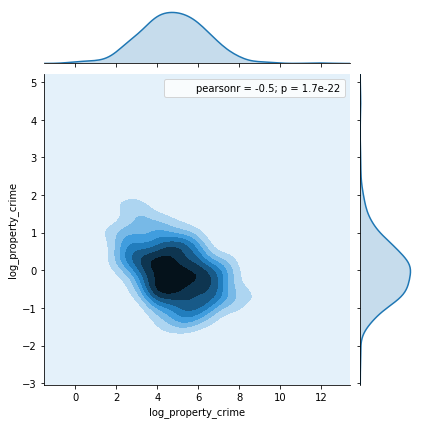

In [9]:
#Write out the model formula.
#Your dependent variable on the right, independent variables on the left
#Use a ~ to represent an '=' from the functional form
linear_formula = 'log_property_crime ~ log_population + robbery'

#Fit the model to our data using the formula.
lg_model = smf.ols(formula=linear_formula, data=data).fit()
params_df = params_df.append(lg_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_model.rsquared))

#residual
baseline_ypred = lg_model.predict()
baseline_residual = baseline_ypred - Y

sns.jointplot(Y, baseline_residual, kind = 'kde')
plt.show()

## 2. Holdout¶

Train 80%, test 20%.

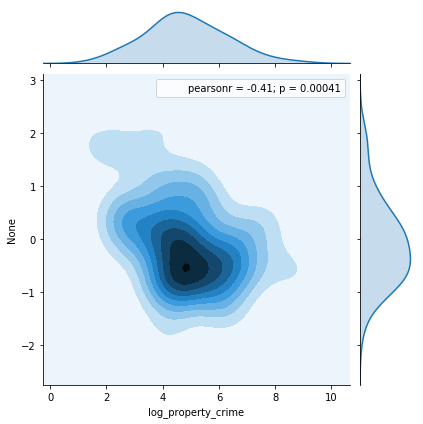

In [10]:
#Use train_test_split to create the necessary training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(data[['log_population', 'robbery']], data['log_property_crime'], test_size=0.2, random_state=20)
holdout_df = pd.concat([X_train, Y_train], axis = 1)

#Fit and get model values
lg_holdout_model = smf.ols(formula=linear_formula, data=holdout_df).fit()
params_df = params_df.append(lg_holdout_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_holdout_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_holdout_model.rsquared))

#Residual
holdout_ypred = lg_holdout_model.predict(X_test)
holdout_residual = holdout_ypred - Y
sns.jointplot(Y, holdout_residual, kind = 'kde')
plt.show()

## 3. Cross-validation¶


Train on data, test on fold. Perform 5 folds and find mean and standard deviation of the scores.

In [11]:
total_points = data.shape[0]
folds = 5
fold_size = int(total_points / folds)
from sklearn.metrics import confusion_matrix

for fold in range(folds):
    test_vals = list(range(fold * fold_size,(fold + 1) * fold_size))
    train_vals = list(range(total_points))
    train_vals = list(set(train_vals) - set(test_vals))
    fold_X_train = X.iloc[train_vals]
    fold_X_test = X.iloc[test_vals]
    fold_Y_train = Y.iloc[train_vals]
    fold_Y_test = Y.iloc[test_vals]
    cross_val_df = pd.concat([fold_X_train, fold_Y_train], axis = 1)
    #Fit and get model values
    lg_cross_val_model = smf.ols(formula=linear_formula, data=cross_val_df).fit()
    params_df = params_df.append(lg_cross_val_model.params, ignore_index = True)
    pvalues_df = pvalues_df.append(lg_cross_val_model.pvalues, ignore_index = True)
    rsquared_series = rsquared_series.append(pd.Series(lg_cross_val_model.rsquared))
    #Residual
    cross_val_ypred = lg_cross_val_model.predict(fold_X_test)
    cross_val_residual = cross_val_ypred - Y

### 4. Transfer model

Train on New York 2013 data, test on New York 2014 data. Evaluate what transferred well, what transferred poorly.

In [12]:
#Read data into a dataframe
data_2014 = '/home/mache/Desktop/Thinkful/Course/Unit 2/ny_2014.csv'
data_2014 = pd.read_csv(data_2014, usecols = ['Population', 'Robbery', 'Property\ncrime'])
display(data_2014.head(3))

,Population,Robbery,Property crime
0,"1,851",0,11
1,"2,568",1,49
2,820,0,1


In [13]:
data_2014.dtypes

Population         object
Robbery            object
Property\ncrime    object
dtype: object

In [14]:
data_2014.dropna(axis = 0, inplace = True)
X_2014 = pd.DataFrame(columns = ['population', 'robbery'])
X_2014['population'] = data_2014['Population'].str.replace(',','').astype(int)
X_2014['log_population'] = X_2014['population'].apply(np.log)
X_2014.drop(['population'], axis = 1, inplace = True)
X_2014['robbery'] = data_2014['Robbery'].str.replace(',','').astype(int)
X_2014['robbery'] = (X_2014['robbery'] > 0).astype(int)

Y_2014 = data_2014['Property\ncrime'].str.replace(',','').astype(float)
Y_2014 = (Y_2014 + 1.0).apply(np.log)
Y_2014 = Y_2014.rename('log_property_crime');

In [15]:
#Implement model on 2014 data
lg_transfer_model = smf.ols(formula=linear_formula, data=pd.concat([X_2014, Y_2014], axis = 1)).fit()
params_df = params_df.append(lg_transfer_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_transfer_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_transfer_model.rsquared))

### Results

In [16]:
comparison_index = ['Baseline', 'Holdout', 'CV 1', 'CV 2', 'CV 3', 'CV 4', 'CV 5', 'Transfer']
params_df.index = comparison_index
pvalues_df.index = comparison_index
rsquared_series.index = comparison_index
display(params_df)
display(pvalues_df)
print('R-Squared comparison:')
display(rsquared_series)

,Intercept,log_population,robbery
Baseline,-5.564818,1.152682,-0.000042
Holdout,-5.771409,1.173901,-0.000050
CV 1,-4.966998,1.091721,-0.000025
CV 2,-5.646420,1.161776,-0.000046
CV 3,-5.558076,1.153263,-0.000043
CV 4,-5.409871,1.131460,0.000892
CV 5,-5.929385,1.188646,-0.000055
Transfer,-4.713786,0.978395,0.855024


,Intercept,log_population,robbery
Baseline,1.040237e-44,1.608907e-99,3.420131e-01
Holdout,2.721004e-38,7.089028e-82,2.632752e-01
CV 1,1.045474e-28,2.658327e-72,5.763684e-01
CV 2,1.138705e-40,6.063274e-87,2.778000e-01
CV 3,1.766707e-37,1.675805e-82,3.374447e-01
CV 4,9.755265e-31,2.414928e-70,1.360882e-01
CV 5,3.626048e-38,2.729535e-80,2.338397e-01
Transfer,1.745351e-30,1.539187e-65,3.842908e-12


R-Squared comparison:


Baseline    0.754717
Holdout     0.767125
CV 1        0.726322
CV 2        0.786181
CV 3        0.768009
CV 4        0.730803
CV 5        0.759330
Transfer    0.760216
dtype: float64